In [ ]:
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
image = Image.open("/content/grayscale.jpeg")

In [ ]:
if image.mode != 'L':
    image = image.convert('L')

In [ ]:
image_array=np.array(image)

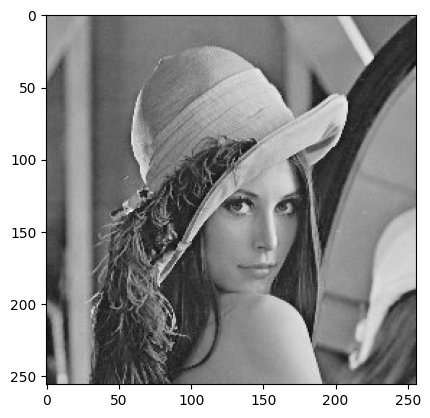

In [ ]:
plt.imshow(image_array, cmap='gray')

In [ ]:
def estimate_prediction_error(image, i, j):
    if i == 0 or j == 0:
        ecap = 0
    else:
        ecap = (abs(image[i-1][j] - image[i-1][j-1]) + abs(image[i][j-1] - image[i-1][j-1])) / 2
    return ecap

In [ ]:
def bits_required_for_prediction_error(ecap):
    if ecap == 0:
        return 0
    n = math.ceil(math.log2(ecap))
    return n if n > 1 else 1

In [ ]:
def compute_prediction(image, i, j):
    if i == 0 or j == 0:
        prediction = 0
        prediction_error = image[i][j]
    else:
        prediction = image[i-1][j] + image[i-1][j-1] - image[i][j-1]
        prediction_error = image[i][j] - prediction
    return prediction, prediction_error

In [ ]:
def encode_next_pixel(prediction_error, B, Bcap):
    m = B - Bcap - 1
    if m > 0:
        encoded_B = "0" * m + "1"
        truncated_error = prediction_error & ((1 << (B - 1)) - 1)
        encoded_pixel = (encoded_B, truncated_error)
    elif B > Bcap:
        m = B - Bcap
        encoded_B = "0" * m + "1"
        truncated_error = prediction_error & ((1 << (B - 1)) - 1)
        encoded_pixel = (encoded_B, truncated_error)
    else:
        encoded_B = "1"
        truncated_error = prediction_error & ((1 << B) - 1)
        encoded_pixel = (encoded_B, truncated_error)
    return encoded_pixel

decompressed_image_ = Image.fromarray(image_array)

In [ ]:
def adjust_lookahead_buffer_size(pattern_length, current_buffer_size):
    if pattern_length == 0:
        new_buffer_size = 2
    else:
        new_buffer_size = 2 ** math.ceil(math.log2(pattern_length + 1))
    return new_buffer_size

In [ ]:
def decode_next_pixel(encoded_data, Bcap):
    prediction_error = 0
    bits_consumed = 0
    while bits_consumed < len(encoded_data):
        if encoded_data[bits_consumed].startswith("0"):
            m = len(encoded_data[bits_consumed]) - 1
            bits_consumed += 1
            if bits_consumed + Bcap > len(encoded_data):
                break
            prediction_error_bits = encoded_data[bits_consumed:bits_consumed + Bcap + 1]
            bits_consumed += Bcap + 1
            prediction_error = int(''.join(prediction_error_bits), 2)
            prediction_error -= (1 << (Bcap + 1))
        else:
            m = len(encoded_data[bits_consumed]) - 1
            bits_consumed += 1
            if bits_consumed + Bcap - 1 > len(encoded_data):
                break
            prediction_error_bits = encoded_data[bits_consumed:bits_consumed + Bcap - 1]
            bits_consumed += Bcap - 1
            prediction_error = int(''.join(prediction_error_bits), 2)
            if m > 0:
                prediction_error -= (1 << (Bcap - 1))
            else:
                prediction_error -= (1 << Bcap)
    return prediction_error, bits_consumed

In [ ]:
def compress_image(image):
    compressed_data = []
    lookahead_buffer_size = 2
    height, width = image.shape
    i, j = 0, 0

    while i < height:
        while j < width:
            pattern_match_length = 0

            while pattern_match_length < lookahead_buffer_size and j + pattern_match_length < width:
                ecap = estimate_prediction_error(image, i, j + pattern_match_length)
                Bcap = bits_required_for_prediction_error(ecap)
                prediction, prediction_error = compute_prediction(image, i, j + pattern_match_length)
                B = bits_required_for_prediction_error(abs(prediction_error))

                if pattern_match_length > 0:
                    encoded_pixel = encode_next_pixel(prediction_error, B, Bcap)
                    compressed_data.append((encoded_pixel[0], len(encoded_pixel[0])))
                j += 1
                pattern_match_length += 1

            j += 1
        i += 1
        j = 0

    return compressed_data

In [ ]:
def decompress_image(compressed_data, width, height):
    decompressed_image = np.zeros((height, width), dtype=np.uint8)
    i, j = 0, 0
    bits_consumed = 0

    for item, num_bits in compressed_data:
        Bcap = bits_required_for_prediction_error(1)
        buffer = []

        for bit_position in range(bits_consumed, bits_consumed + num_bits):
            buffer.append(item[bit_position - bits_consumed])

        while buffer:
            try:
                prediction_error, B = decode_next_pixel(buffer, Bcap)
                prediction, _ = compute_prediction(decompressed_image, i, j)
                decompressed_image[i, j] = max(0, min(255, prediction + prediction_error))
                bits_consumed += B
                if bits_consumed >= num_bits:
                    break
            except ValueError:
                break

            j += 1

            if j == width:
                j = 0
                i += 1

                if i == height:
                    return decompressed_image

    return decompressed_image

# Load a grayscale image (replace 'input_image.jpg' with your image file)
input_image = Image.open("grayscale.jpeg").convert("L")
image_array = np.array(input_image)

# Perform image compression
compressed_data = compress_image(image_array)

# Perform image decompression
decompressed_image = decompress_image(compressed_data, image_array.shape[1], image_array.shape[0])

# Save the decompressed image
decompressed_image = Image.fromarray(decompressed_image)


decompressed_image_.save("decompressed_image.jpeg")

<ipython-input-48-2e7a183c1a49>:5: RuntimeWarning: overflow encountered in ubyte_scalars
  ecap = (abs(image[i-1][j] - image[i-1][j-1]) + abs(image[i][j-1] - image[i-1][j-1])) / 2
<ipython-input-50-d23016c9aaad>:6: RuntimeWarning: overflow encountered in ubyte_scalars
  prediction = image[i-1][j] + image[i-1][j-1] - image[i][j-1]
<ipython-input-50-d23016c9aaad>:7: RuntimeWarning: overflow encountered in ubyte_scalars
  prediction_error = image[i][j] - prediction


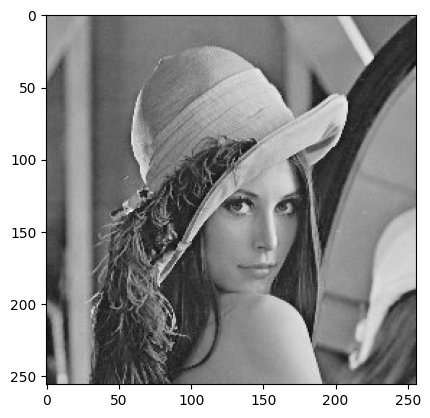

In [ ]:
plt.imshow(decompressed_image_, cmap='gray')